In [16]:
import numpy as np
import pandas as pd
peaks = pd.read_csv('combined_peaks_named.csv')

biotic_peaks = peaks[peaks['class'] == 1][['RT1_center','RT2_center','m/z']].to_numpy()
abiotic_peaks = peaks[peaks['class'] == 0][['RT1_center','RT2_center','m/z']].to_numpy()

biotic_peaks

# normalization across columns (RT1, RT2, m/z) sklearn
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(np.concatenate([biotic_peaks, abiotic_peaks] , axis=0))
biotic_peaks_normalized = scaler.transform(biotic_peaks)
abiotic_peaks_normalized = scaler.transform(abiotic_peaks)

biotic_peaks_normalized

array([[ 1.21462169,  0.98020059,  0.27113846],
       [ 0.14404689, -0.11142356,  0.27113846],
       [ 0.29998986, -0.05496024,  0.40237333],
       ...,
       [ 1.36355599, -1.14658439,  0.11178182],
       [ 0.97983114, -0.77016227,  0.11178182],
       [ 1.63514207,  0.7167051 ,  0.11178182]])

In [17]:
import numpy as np
from sklearn.neighbors import KernelDensity
from scipy.optimize import approx_fprime


In [18]:
# Fit KDE to the data
from sklearn.model_selection import GridSearchCV


params = {'bandwidth': np.linspace(0.1, 2.0, 30)}
grid = GridSearchCV(KernelDensity(kernel='gaussian'), params)
grid.fit(biotic_peaks_normalized)

print("Best bandwidth:", grid.best_estimator_.bandwidth)

Best bandwidth: 0.23103448275862068


In [19]:
# Fit KDE to the data
kde = KernelDensity(bandwidth=0.23, kernel='gaussian')
kde.fit(biotic_peaks_normalized)

# Define a function to compute log-density
def log_density(p):
    return kde.score_samples(p.reshape(1, -1))[0]

score_vectors = []
for point in abiotic_peaks_normalized:
    # Compute log-density at the given point
    log_density_value = log_density(np.array(point))

    # Compute the score vector (gradient of log-density)
    score_vector = approx_fprime(np.array(point), log_density, epsilon=1e-7)

    # print(np.exp(log_density_value), score_vector)
    score_vectors.append(score_vector)

In [25]:
svs = np.array(score_vectors)
# svs = scaler.inverse_transform(svs)

# mean across columns
np.mean(svs, axis=0)

svs

array([[ 1.48550066e+00,  1.32709363e+00, -2.57981605e-01],
       [-1.34511432e+00,  2.38095440e+00, -1.31302457e+00],
       [ 6.14200317e+00,  5.74918690e-02,  1.23969832e+00],
       [ 6.17785438e+00,  6.62032722e-01,  1.27874950e+00],
       [ 1.64795429e+00,  1.19832175e-01,  1.03911062e-01],
       [ 7.95126566e+00, -7.68543377e+00,  9.72075398e-02],
       [ 7.69417115e+00, -7.10208719e+00,  5.02309261e-01],
       [ 7.71018857e+00, -7.11203059e+00,  5.09735258e-01],
       [ 2.20847881e+00, -1.44451162e+00,  2.57066989e+00],
       [ 2.36229978e+00, -1.36745365e+00,  3.89605801e+00],
       [-4.61300522e-01, -2.12197075e+00, -3.57932710e-01],
       [ 1.45060318e+00, -4.45483961e-01, -1.99798110e+00],
       [ 2.46251877e+00, -1.24550992e+00,  5.51099883e+00],
       [ 8.48152793e+00, -7.95841171e-01,  3.60552940e+00],
       [ 2.45685394e+00, -1.25566369e+00,  5.38506429e+00],
       [-4.31471356e-01,  1.76532369e+00, -1.59658790e+00],
       [ 1.00494797e+00,  5.02302906e-01

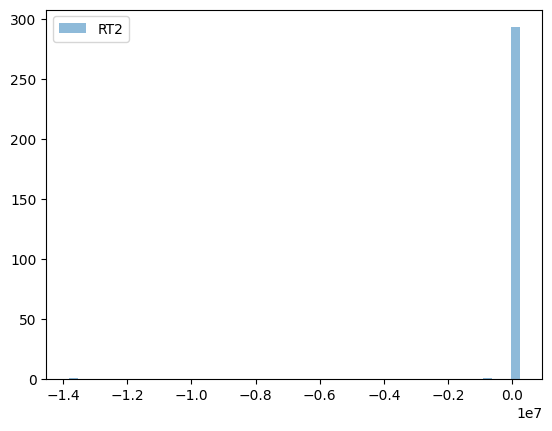

In [31]:
# Plot histogram of the scores per column
import matplotlib.pyplot as plt
# plt.hist(svs[:, 0], bins=50, alpha=0.5, label='RT1')
plt.hist(svs[:, 1], bins=50, alpha=0.5, label='RT2')
# plt.hist(svs[:, 2], bins=50, alpha=0.5, label='m/z')
plt.legend()
plt.show()

# Modeling accuracy

Log-likelihood: -661.4237795884117
Mean p-value: [0.23300904 0.1525723  0.67514404]


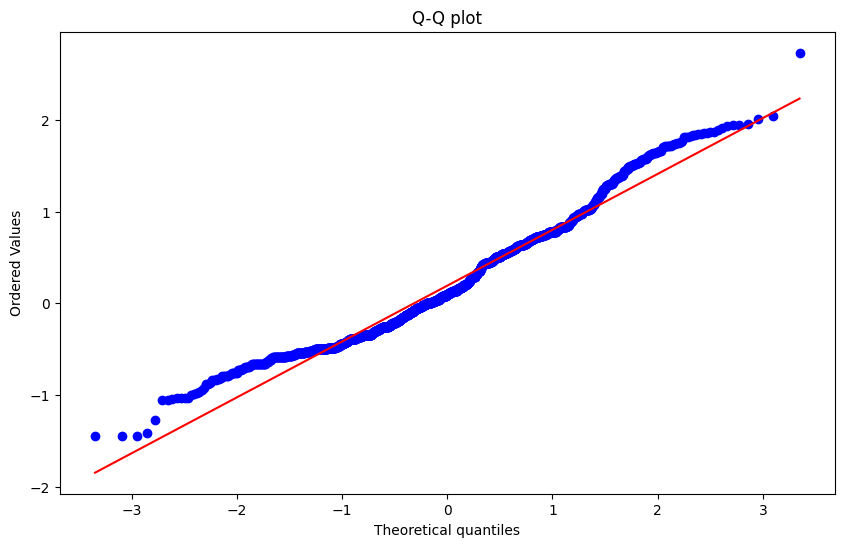

In [200]:
import numpy as np
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from scipy import stats

# Assuming biotic_peaks_normalized is your data

# 1. Cross-validation for bandwidth selection
params = {'bandwidth': np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params, cv=5)
grid.fit(biotic_peaks_normalized)

optimal_kde = grid.best_estimator_

# 3. Log-likelihood
log_likelihood = optimal_kde.score(biotic_peaks_normalized)
print(f"Log-likelihood: {log_likelihood}")

# 4. Kolmogorov-Smirnov test

p_values = []
for i in range(10000):
    kde_samples = optimal_kde.sample(n_samples=len(biotic_peaks_normalized))
    ks_statistic, p_value = stats.ks_2samp(biotic_peaks_normalized, kde_samples)
    # print(f"KS test statistic: {ks_statistic}, p-value: {p_value}")
    p_values.append(p_value)

p_values = np.array(p_values)
print(f"Mean p-value: {np.mean(p_values, axis=0)}")


# 5. Q-Q plot
plt.figure(figsize=(10, 6))
stats.probplot(biotic_peaks_normalized.flatten(), dist="norm", plot=plt)
plt.title("Q-Q plot")
plt.show()